In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [59]:
# 1. Generate simulated data
def generate_time_series_data(start_date='2020-01-01', periods=60):
    """
    Generate time series data with trend, seasonality, and randomness
    """
    # Generate date sequence
    dates = pd.date_range(start=start_date, periods=periods, freq='M')
   
    # Create trend component (linear growth)
    trend = np.linspace(100, 300, periods)
   
    # Create seasonal component (12-month cycle)
    seasonal = 50 * np.sin(2 * np.pi * np.arange(periods) / 12)
   
    # Create random component
    random = np.random.normal(0, 20, periods)
   
    # Combine all components
    sales = trend + seasonal + random
   
    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'sales': sales,
        'month': dates.month
    })
    df.set_index('date', inplace=True)
   
    return df
# Generate data
df = generate_time_series_data(periods=60)
print("Data Preview:")
print(df.head())
print(f"\nData Shape: {df.shape}")

Data Preview:
                 sales  month
date                         
2020-01-31  108.507238      1
2020-02-29  126.013784      2
2020-03-31  168.125163      3
2020-04-30  183.138751      4
2020-05-31  139.364421      5

Data Shape: (60, 2)


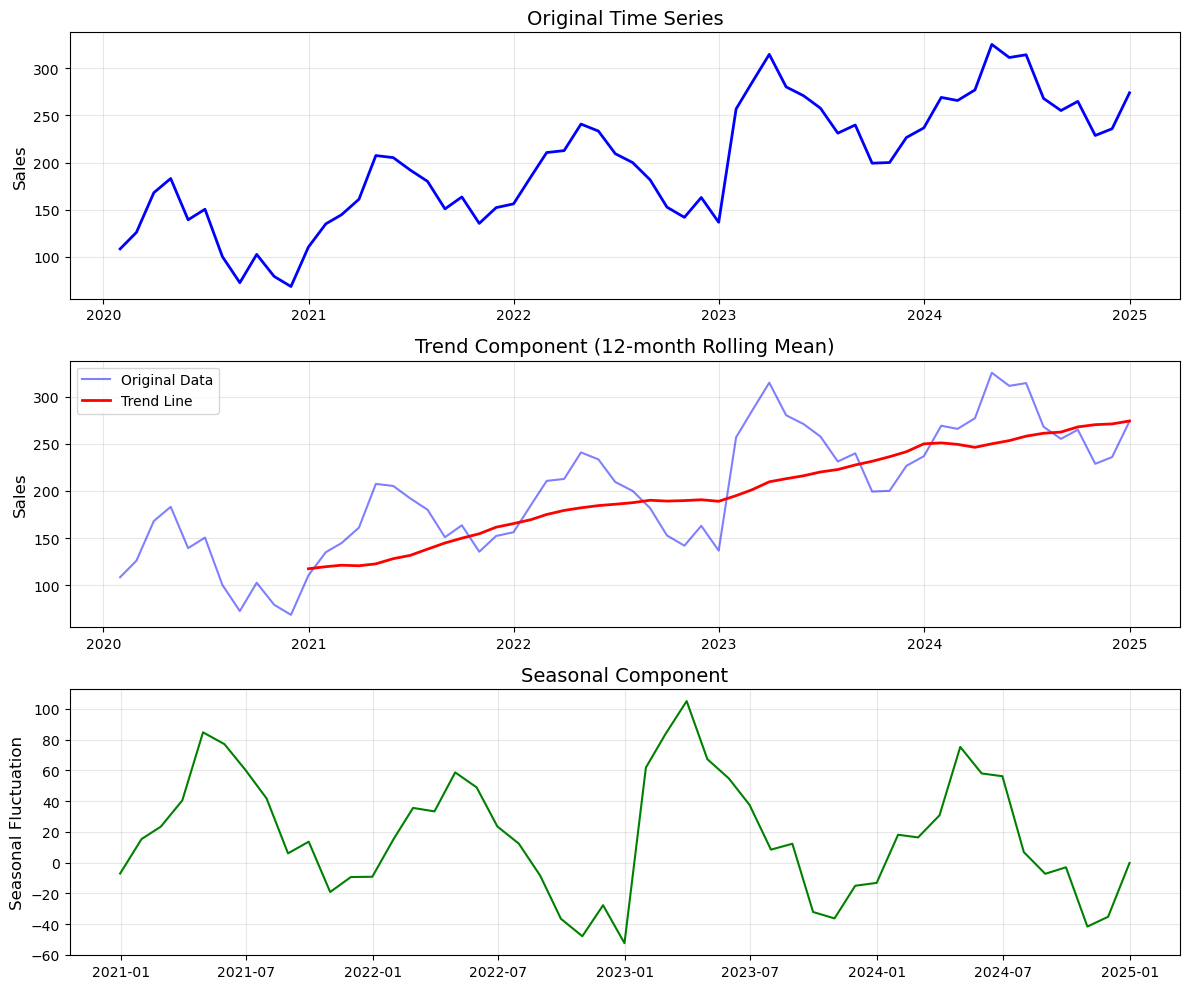

In [60]:
# 2. Visualize data
def plot_time_series_components(df):
    """
    Plot time series and its components
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
   
    # Original series
    axes[0].plot(df.index, df['sales'], 'b-', linewidth=2)
    axes[0].set_title('Original Time Series', fontsize=14)
    axes[0].set_ylabel('Sales', fontsize=12)
    axes[0].grid(True, alpha=0.3)
   
    # Rolling mean (trend)
    rolling_mean = df['sales'].rolling(window=12).mean()
    axes[1].plot(df.index, df['sales'], 'b-', alpha=0.5)
    axes[1].plot(df.index, rolling_mean, 'r-', linewidth=2)
    axes[1].set_title('Trend Component (12-month Rolling Mean)', fontsize=14)
    axes[1].set_ylabel('Sales', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(['Original Data', 'Trend Line'])
   
    # Seasonality
    seasonal_component = df['sales'] - rolling_mean
    axes[2].plot(df.index, seasonal_component, 'g-')
    axes[2].set_title('Seasonal Component', fontsize=14)
    axes[2].set_ylabel('Seasonal Fluctuation', fontsize=12)
    axes[2].grid(True, alpha=0.3)
   
    plt.tight_layout()
    plt.show()
plot_time_series_components(df)

Stationarity Test


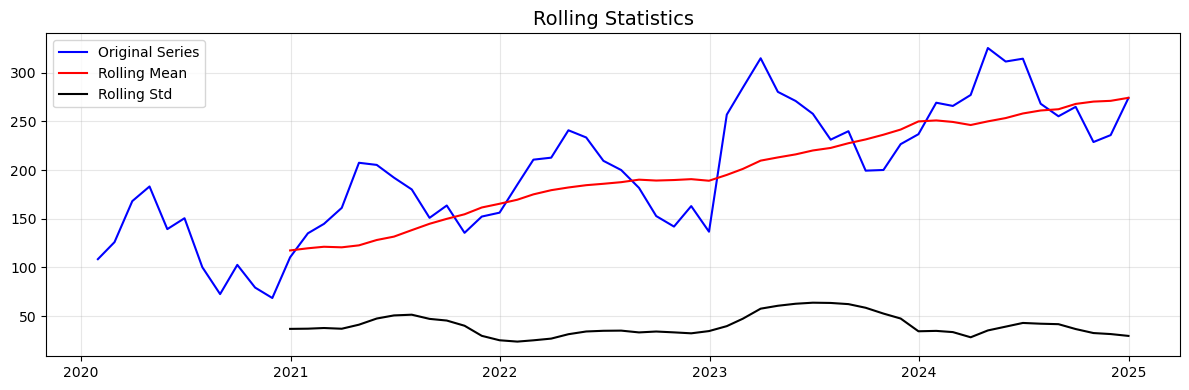

Test Statistic            -0.513247
p-value                    0.889405
Lags Used                  9.000000
Number of Observations    50.000000
Critical Value (1%)       -3.568486
Critical Value (5%)       -2.921360
Critical Value (10%)      -2.598662
dtype: float64

Conclusion: p-value = 0.8894 => Series is non-stationary


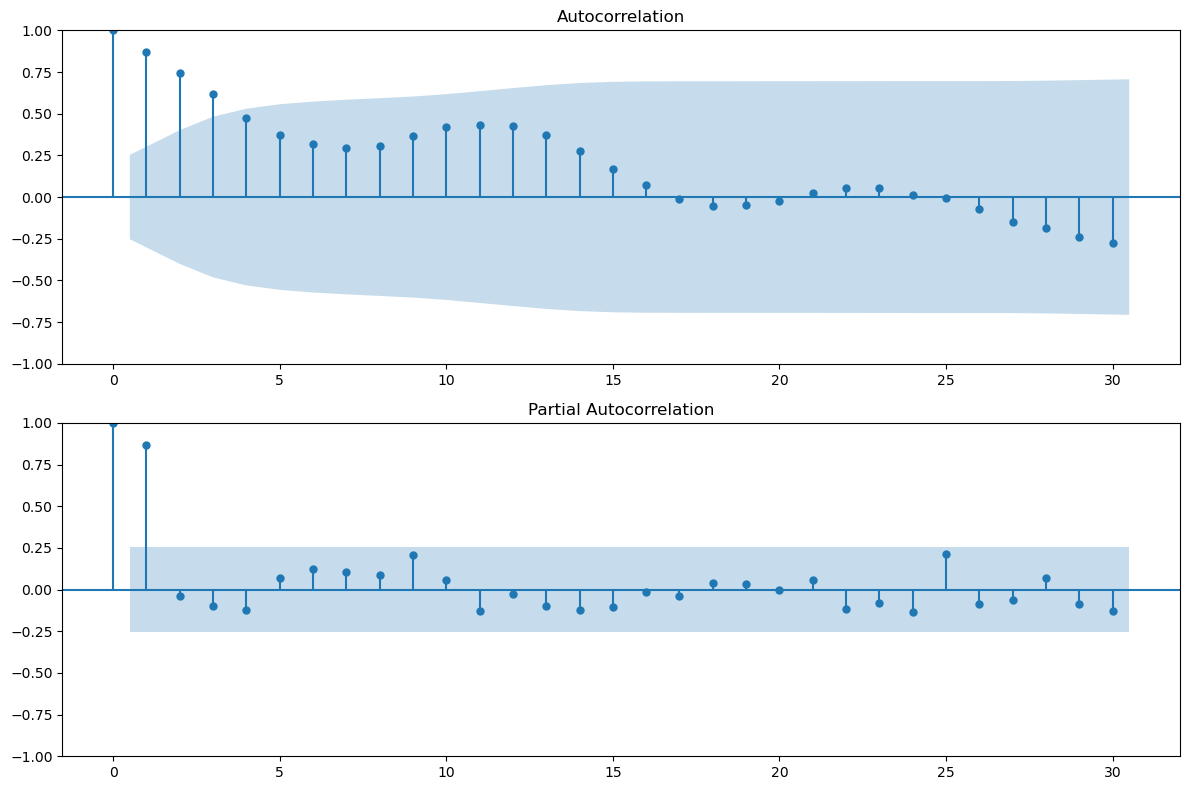

In [61]:
# 3. Stationarity test
def check_stationarity(timeseries):
    """
    Check stationarity of time series
    """
    print("=" * 50)
    print("Stationarity Test")
    print("=" * 50)
   
    # Calculate rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
   
    # Plot rolling statistics
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))  # Change to 1 subplot
    ax.plot(timeseries, color='blue', label='Original Series')
    ax.plot(rolmean, color='red', label='Rolling Mean')
    ax.plot(rolstd, color='black', label='Rolling Std')
    ax.set_title('Rolling Statistics', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()  # Add this to explicitly display the figure
   
    # ADF test
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations'])
   
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
   
    print(dfoutput)
    print(f"\nConclusion: p-value = {dftest[1]:.4f}", end=' ')
    if dftest[1] > 0.05:
        print("=> Series is non-stationary")
    else:
        print("=> Series is stationary")
   
    # Autocorrelation and partial autocorrelation plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(timeseries, lags=30, ax=ax1)
    plot_pacf(timeseries, lags=30, ax=ax2)
    plt.tight_layout()
    plt.show()
   
    return dftest[1]
p_value = check_stationarity(df['sales'])


Series is non-stationary, performing differencing...


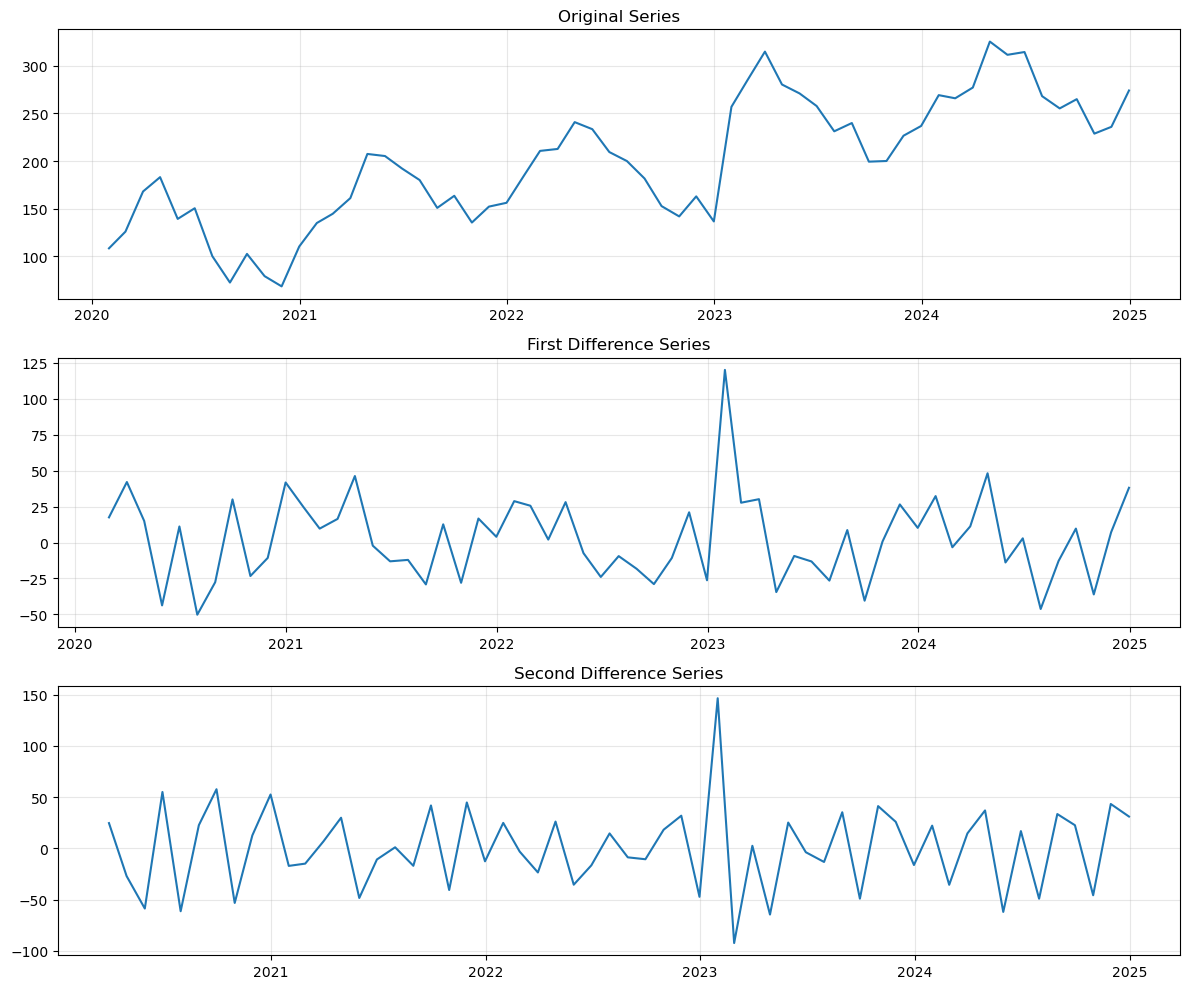


 1 Order Difference Stationarity Test
p-value: 0.0000 => Stationary


In [62]:
# 4. Differencing (if non-stationary)
def make_stationary(timeseries):
    """
    Make series stationary through differencing
    """
    # First difference
    diff1 = timeseries.diff().dropna()
   
    # Second difference
    diff2 = diff1.diff().dropna()
   
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
   
    # Original series
    axes[0].plot(timeseries)
    axes[0].set_title('Original Series', fontsize=12)
    axes[0].grid(True, alpha=0.3)
   
    # First difference
    axes[1].plot(diff1)
    axes[1].set_title('First Difference Series', fontsize=12)
    axes[1].grid(True, alpha=0.3)
   
    # Second difference
    axes[2].plot(diff2)
    axes[2].set_title('Second Difference Series', fontsize=12)
    axes[2].grid(True, alpha=0.3)
   
    plt.tight_layout()
    plt.show()
   
    # Test stationarity after differencing
    for i, diff_series in enumerate([diff1, diff2], 1):
        print(f"\n{'='*30}")
        print(f" {i} Order Difference Stationarity Test")
        print(f"{'='*30}")
        dftest = adfuller(diff_series, autolag='AIC')
        print(f"p-value: {dftest[1]:.4f}", end=" ")
        if dftest[1] < 0.05:
            print("=> Stationary")
            return diff_series, i
        else:
            print("=> Non-stationary")
   
    return diff1, 1
# If needed, perform differencing
if p_value > 0.05:
    print("\nSeries is non-stationary, performing differencing...")
    stationary_series, d = make_stationary(df['sales'])
else:
    stationary_series = df['sales']
    d = 0

In [63]:
# 5. ARIMA model implementation
def arima_model_pipeline(data, test_size=12, order=(1, 1, 1)):
    """
    ARIMA model full pipeline
    """
    print("=" * 50)
    print("ARIMA Model Training")
    print("=" * 50)
   
    # Split train and test
    train = data.iloc[:-test_size]
    test = data.iloc[-test_size:]
   
    print(f"Train Size: {len(train)}")
    print(f"Test Size: {len(test)}")
   
    # Train ARIMA model
    model = ARIMA(train, order=order)
    model_fit = model.fit()
   
    print("\nModel Parameters:")
    print(model_fit.summary())
   
    # Forecast
    forecast = model_fit.forecast(steps=test_size)
   
    # Calculate forecast intervals
    forecast_index = test.index
    forecast_series = pd.Series(forecast, index=forecast_index)
   
    return model_fit, train, test, forecast_series
# Try different (p,d,q) combinations
def find_best_arima(data, p_range=(0, 3), d_range=(0, 2), q_range=(0, 3)):
    """
    Find optimal ARIMA parameters
    """
    best_aic = np.inf
    best_order = None
    best_model = None
   
    train = data.iloc[:-12]
    test = data.iloc[-12:]
   
    results = []
   
    for p in range(p_range[0], p_range[1]+1):
        for d in range(d_range[0], d_range[1]+1):
            for q in range(q_range[0], q_range[1]+1):
                try:
                    model = ARIMA(train, order=(p, d, q))
                    model_fit = model.fit()
                    aic = model_fit.aic
                   
                    results.append({
                        'order': (p, d, q),
                        'aic': aic,
                        'bic': model_fit.bic
                    })
                   
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                        best_model = model_fit
                       
                    print(f"ARIMA{p,d,q} - AIC: {aic:.2f}")
                   
                except Exception as e:
                    continue
   
    # Display results
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('aic').head(10)
   
    print("\n" + "="*50)
    print("Optimal Parameters Search Results")
    print("="*50)
    print(results_df.to_string())
    print(f"\nBest Model: ARIMA{best_order} (AIC: {best_aic:.2f})")
   
    return best_order, best_model
# Find optimal parameters
best_order, best_model = find_best_arima(df['sales'])
# Train model with optimal parameters
model_fit, train, test, forecast = arima_model_pipeline(
    df['sales'],
    order=best_order
)

ARIMA(0, 0, 0) - AIC: 528.81
ARIMA(0, 0, 1) - AIC: 496.16
ARIMA(0, 0, 2) - AIC: 481.91
ARIMA(0, 0, 3) - AIC: 472.42
ARIMA(0, 1, 0) - AIC: 455.52
ARIMA(0, 1, 1) - AIC: 457.38
ARIMA(0, 1, 2) - AIC: 457.80
ARIMA(0, 1, 3) - AIC: 459.07
ARIMA(0, 2, 0) - AIC: 475.55
ARIMA(0, 2, 1) - AIC: 452.33
ARIMA(0, 2, 2) - AIC: 454.12
ARIMA(0, 2, 3) - AIC: 454.22
ARIMA(1, 0, 0) - AIC: 467.33
ARIMA(1, 0, 1) - AIC: 468.74
ARIMA(1, 0, 2) - AIC: 468.45
ARIMA(1, 0, 3) - AIC: 468.39
ARIMA(1, 1, 0) - AIC: 457.34
ARIMA(1, 1, 1) - AIC: 459.16
ARIMA(1, 1, 2) - AIC: 459.37
ARIMA(1, 1, 3) - AIC: 458.73
ARIMA(1, 2, 0) - AIC: 461.01
ARIMA(1, 2, 1) - AIC: 454.05
ARIMA(1, 2, 2) - AIC: 456.13
ARIMA(1, 2, 3) - AIC: 457.99
ARIMA(2, 0, 0) - AIC: 468.45
ARIMA(2, 0, 1) - AIC: 469.39
ARIMA(2, 0, 2) - AIC: 468.59
ARIMA(2, 0, 3) - AIC: 470.27
ARIMA(2, 1, 0) - AIC: 458.42
ARIMA(2, 1, 1) - AIC: 460.41
ARIMA(2, 1, 2) - AIC: 447.34
ARIMA(2, 1, 3) - AIC: 464.14
ARIMA(2, 2, 0) - AIC: 460.29
ARIMA(2, 2, 1) - AIC: 462.21
ARIMA(2, 2, 2)

In [64]:
# 6. Exponential smoothing model (for comparison)
def exponential_smoothing_model(data, test_size=12):
    """
    Exponential smoothing model
    """
    print("\n" + "="*50)
    print("Exponential Smoothing Model")
    print("="*50)
   
    train = data.iloc[:-test_size]
    test = data.iloc[-test_size:]
   
    # Holt-Winters triple exponential smoothing
    model = ExponentialSmoothing(
        train,
        seasonal_periods=12,
        trend='add',
        seasonal='add'
    )
   
    model_fit = model.fit()
   
    # Forecast
    forecast = model_fit.forecast(test_size)
    forecast_series = pd.Series(forecast, index=test.index)
   
    print(model_fit.summary())
   
    return model_fit, forecast_series
# Train exponential smoothing model
es_model, es_forecast = exponential_smoothing_model(df['sales'])


Exponential Smoothing Model
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    sales   No. Observations:                   48
Model:             ExponentialSmoothing   SSE                          15029.862
Optimized:                         True   AIC                            307.836
Trend:                         Additive   BIC                            337.776
Seasonal:                      Additive   AICC                           331.423
Seasonal Periods:                    12   Date:                 Mon, 12 Jan 2026
Box-Cox:                          False   Time:                         13:53:17
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.4901e-08                alpha                 T

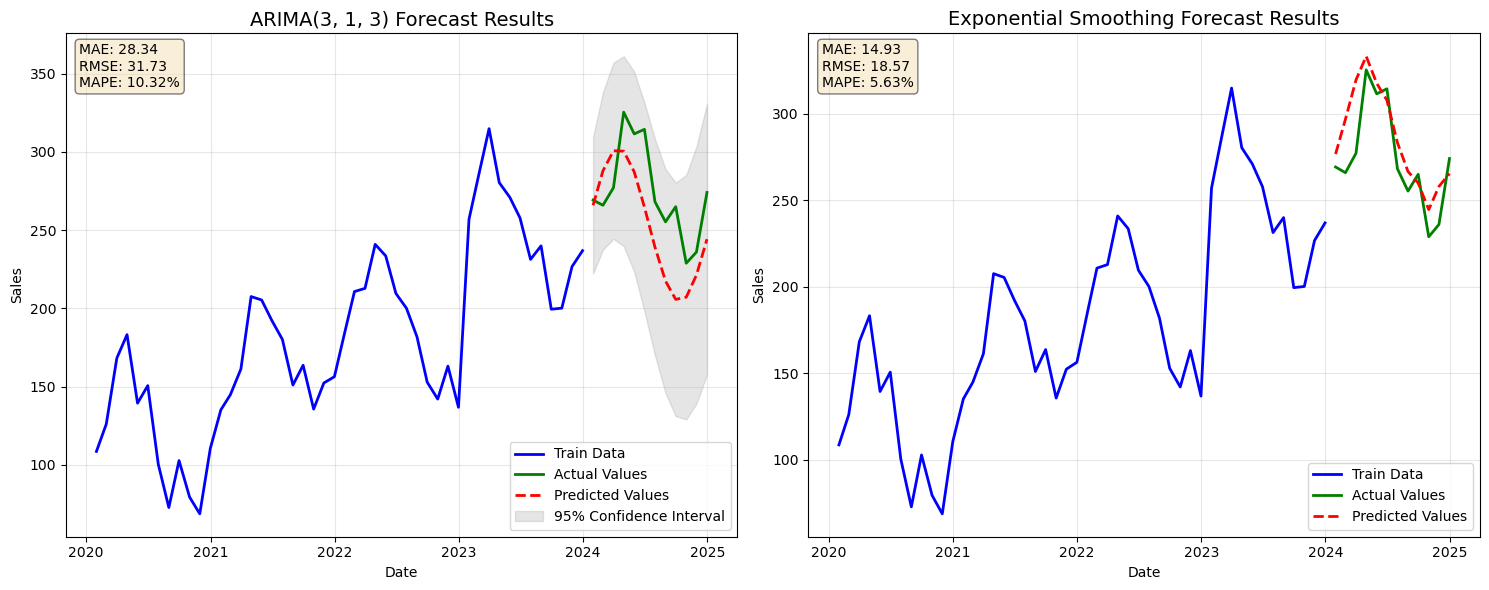


Model Performance Comparison
                Model       MAE      RMSE   MAPE(%)
       ARIMA(3, 1, 3) 28.336919 31.734968 10.323335
Exponential Smoothing 14.932606 18.566232  5.626018


In [65]:
# 7. Model evaluation and visualization
def evaluate_and_visualize(models_dict, test_data):
    """
    Evaluate multiple models and visualize results
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Changed to 1 row, 2 columns to avoid empty plots
   
    metrics_results = []
   
    for idx, (model_name, forecast_series) in enumerate(models_dict.items()):
        # Calculate error metrics
        mae = mean_absolute_error(test_data, forecast_series)
        rmse = np.sqrt(mean_squared_error(test_data, forecast_series))
        mape = np.mean(np.abs((test_data - forecast_series) / test_data)) * 100
       
        metrics_results.append({
            'Model': model_name,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE(%)': mape
        })
       
        # Plot forecast results
        row = idx // 2
        col = idx % 2
       
        axes[col].plot(train.index, train.values, 'b-', label='Train Data', linewidth=2)  # Use axes[col] since 1D array now
        axes[col].plot(test_data.index, test_data.values, 'g-', label='Actual Values', linewidth=2)
        axes[col].plot(forecast_series.index, forecast_series.values,
                           'r--', label='Predicted Values', linewidth=2)
       
        # Fill prediction interval
        if 'ARIMA' in model_name:  # Changed condition to check if 'ARIMA' is in the name
            # Get prediction interval
            forecast_result = model_fit.get_forecast(steps=len(test_data))
            conf_int = forecast_result.conf_int()
           
            axes[col].fill_between(
                forecast_series.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1],
                color='gray', alpha=0.2, label='95% Confidence Interval'
            )
       
        axes[col].set_title(f'{model_name} Forecast Results', fontsize=14)
        axes[col].set_xlabel('Date')
        axes[col].set_ylabel('Sales')
        axes[col].legend()
        axes[col].grid(True, alpha=0.3)
       
        # Add error metrics to plot
        textstr = f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%'
        axes[col].text(0.02, 0.98, textstr, transform=axes[col].transAxes,
                           fontsize=10, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
   
    # Adjust layout
    plt.tight_layout()
    plt.show()
   
    # Display metrics comparison
    metrics_df = pd.DataFrame(metrics_results)
    print("\n" + "="*50)
    print("Model Performance Comparison")
    print("="*50)
    print(metrics_df.to_string(index=False))
   
    return metrics_df
# Prepare model comparison
models_dict = {
    f'ARIMA{best_order}': forecast,
    'Exponential Smoothing': es_forecast
}
# Evaluate models
metrics_df = evaluate_and_visualize(models_dict, test)


Future 12 Months Forecast


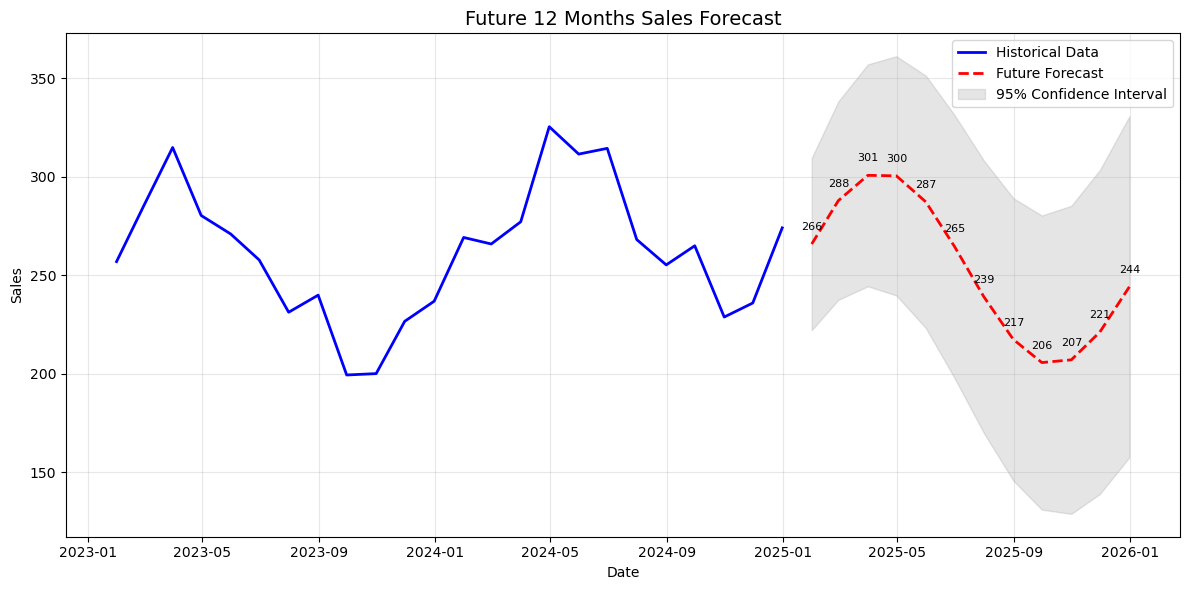


Forecast Results:
2025-01-31    265.808278
2025-02-28    287.810710
2025-03-31    300.642524
2025-04-30    300.383564
2025-05-31    287.168999
2025-06-30    264.652827
2025-07-31    239.047760
2025-08-31    217.405781
2025-09-30    205.676496
2025-10-31    207.071492
2025-11-30    221.185017
2025-12-31    244.111665
Freq: ME


In [66]:
# 8. Future forecast
def future_forecast(model, model_type='arima', future_steps=12):
    """
    Perform future forecast
    """
    print("\n" + "="*50)
    print(f"Future {future_steps} Months Forecast")
    print("="*50)
   
    if model_type == 'arima':
        forecast_result = model.get_forecast(steps=future_steps)
        forecast_values = forecast_result.predicted_mean
        conf_int = forecast_result.conf_int()
    else:
        forecast_values = model.forecast(future_steps)
        conf_int = None
   
    # Generate future dates
    last_date = df.index[-1]
    future_dates = pd.date_range(
        start=last_date + pd.DateOffset(months=1),
        periods=future_steps,
        freq='M'
    )
   
    forecast_series = pd.Series(forecast_values.values, index=future_dates)
   
    # Visualize future forecast
    plt.figure(figsize=(12, 6))
   
    # Plot historical data
    plt.plot(df.index[-24:], df['sales'].iloc[-24:],
             'b-', linewidth=2, label='Historical Data')
   
    # Plot forecast values
    plt.plot(forecast_series.index, forecast_series.values,
             'r--', linewidth=2, label='Future Forecast')
   
    # Add confidence interval
    if conf_int is not None:
        plt.fill_between(
            forecast_series.index,
            conf_int.iloc[:, 0],
            conf_int.iloc[:, 1],
            color='gray', alpha=0.2, label='95% Confidence Interval'
        )
   
    plt.title(f'Future {future_steps} Months Sales Forecast', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)
   
    # Add specific values
    for date, value in zip(forecast_series.index, forecast_series.values):
        plt.annotate(f'{value:.0f}',
                     xy=(date, value),
                     xytext=(0, 10),
                     textcoords='offset points',
                     ha='center',
                     fontsize=8)
   
    plt.tight_layout()
    plt.show()
   
    # Print forecast results
    print("\nForecast Results:")
    print(forecast_series.to_string())
   
    return forecast_series
# Perform future forecast
future_series = future_forecast(model_fit, 'arima', 12)

In [67]:
# 9. Practical application suggestions
def time_series_analysis_guide():
    """
    Time Series Analysis Practical Guide
    """
    print("\n" + "="*60)
    print("Time Series Analysis Practical Guide")
    print("="*60)
   
    guidelines = [
        {
            "Step": "1. Data Exploration",
            "Operation": "Plot time series, calculate statistics, check missing values",
            "Tools": "pandas.describe(), matplotlib"
        },
        {
            "Step": "2. Stationarity Test",
            "Operation": "ADF test, observe rolling statistics",
            "Tools": "adfuller()"
        },
        {
            "Step": "3. Differencing",
            "Operation": "Perform 1-2 order differencing until stationary",
            "Tools": "pandas.diff()"
        },
        {
            "Step": "4. Determine Model Parameters",
            "Operation": "Observe ACF/PACF plots, grid search",
            "Tools": "plot_acf(), plot_pacf()"
        },
        {
            "Step": "5. Model Training",
            "Operation": "ARIMA/Exponential Smoothing/Prophet",
            "Tools": "ARIMA(), ExponentialSmoothing()"
        },
        {
            "Step": "6. Model Evaluation",
            "Operation": "Calculate MAE/RMSE/MAPE, residual analysis",
            "Tools": "sklearn.metrics"
        },
        {
            "Step": "7. Forecast Application",
            "Operation": "Short-term forecast, interval estimation",
            "Tools": "forecast(), get_forecast()"
        }
    ]
   
    guidelines_df = pd.DataFrame(guidelines)
    print(guidelines_df.to_string(index=False))
   
    print("\n" + "="*60)
    print("Common Problems and Solutions")
    print("="*60)
   
    problems = [
        "Problem: Series not stationary",
        "Solution: Perform differencing, consider seasonal differencing",
        "",
        "Problem: Outliers exist",
        "Solution: Use robust models or handle outliers",
        "",
        "Problem: Changing seasonal patterns",
        "Solution: Use dynamic seasonality in exponential smoothing",
        "",
        "Problem: Multivariate time series",
        "Solution: Consider VAR or multivariate Prophet",
        "",
        "Problem: Inaccurate long-term forecasts",
        "Solution: Incorporate external variables, use machine learning methods"
    ]
   
    for problem in problems:
        print(problem)
# Display practical guide
time_series_analysis_guide()


Time Series Analysis Practical Guide
                         Step                                                    Operation                           Tools
          1. Data Exploration Plot time series, calculate statistics, check missing values   pandas.describe(), matplotlib
         2. Stationarity Test                         ADF test, observe rolling statistics                      adfuller()
              3. Differencing              Perform 1-2 order differencing until stationary                   pandas.diff()
4. Determine Model Parameters                          Observe ACF/PACF plots, grid search         plot_acf(), plot_pacf()
            5. Model Training                          ARIMA/Exponential Smoothing/Prophet ARIMA(), ExponentialSmoothing()
          6. Model Evaluation                   Calculate MAE/RMSE/MAPE, residual analysis                 sklearn.metrics
      7. Forecast Application                     Short-term forecast, interval estimation      forec

In [68]:
# 10. Save results
def save_results(df, forecast_results, model_name="arima"):
    """
    Save forecast results
    """
    # Create results DataFrame
    results_df = pd.DataFrame({
        'date': df.index,
        'actual_sales': df['sales'].values  # Use .values to avoid carrying over the index
    })
   
    # Add forecast results
    for forecast_name, forecast_series in forecast_results.items():
        # Create forecast column
        temp_df = pd.DataFrame({
            'date': forecast_series.index,
            f'forecast_{forecast_name}': forecast_series.values
        })
       
        # Merge to results DataFrame
        results_df = pd.merge(results_df, temp_df, on='date', how='left')
   
    # Save to CSV
    results_df.to_csv(f'time_series_forecast_results_{model_name}.csv', index=False)
    print(f"\nResults saved to: time_series_forecast_results_{model_name}.csv")
   
    return results_df

In [69]:
# Save results
results_df = save_results(df, {'arima': forecast, 'exponential_smoothing': es_forecast})
print("\n" + "="*60)
print("Time Series Analysis Completed!")
print("="*60)


Results saved to: time_series_forecast_results_arima.csv

Time Series Analysis Completed!
